In [1]:
import numpy as np
import pandas as pd
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql import functions as f

spark = SparkSession.builder.enableHiveSupport().getOrCreate()

# Suppresses user warinig messages in Python
import warnings
warnings.simplefilter("ignore", UserWarning)

# Suppresses `WARN` messages in JVM
spark.sparkContext.setLogLevel("ERROR")

NOTE: SPARK_PREPEND_CLASSES is set, placing locally compiled Spark classes ahead of assembly.
21/11/05 16:59:15 WARN Utils: Your hostname, maropus-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.3.4 instead (on interface en0)
21/11/05 16:59:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/05 16:59:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import importlib
ptesting_model = importlib.import_module("ptesting-model")

In [3]:
expected_input_cols = [                                                                                                                                                                                                                       
    'author',
    'case when length(sha) > 0 then sha else sha(string(random())) end sha',
    'commit_date',
    'array_distinct(failed_tests) failed_tests',
    'files' 
]

log_data_df = spark.read.format('json').load('../models/spark/logs/github-logs.json').selectExpr(expected_input_cols).where('size(failed_tests) < 64')

In [4]:
log_data_df.orderBy(f.expr('commit_date').desc()).show(3)

+------------+--------------------+-------------------+--------------------+--------------------+
|      author|                 sha|        commit_date|        failed_tests|               files|
+------------+--------------------+-------------------+--------------------+--------------------+
|         c21|9b8b9ef7efa3ab055...|2021/10/26 23:36:54|                  []|[{{10, 10, 0, sql...|
|     xkrogen|bfb98833ddd60db80...|2021/10/26 22:16:21|                  []|[{{9, 18, 9, core...|
|AngersZhuuuu|d03a64cf0b4e5e303...|2021/10/26 14:17:48|[org.apache.spark...|[{{288, 288, 0, s...|
+------------+--------------------+-------------------+--------------------+--------------------+
only showing top 3 rows



In [5]:
import json
from pathlib import Path 
excluded_tests = json.loads(Path('../models/spark/logs/excluded-tests.json').read_text())
log_data_df = ptesting_model._exclude_tests_from(log_data_df, excluded_tests)

In [6]:
from ptesting import github_utils

test_files = json.loads(Path('../models/spark/indexes/latest/test-files.json').read_text())
commits_ = json.loads(Path('../models/spark/logs/commits.json').read_text())
commits = list(map(lambda c: github_utils.from_github_datetime(c[0]), commits_))
updated_file_stats = json.loads(Path('../models/spark/logs/updated-file-stats.json').read_text())
failed_tests = json.loads(Path('../models/spark/failed-tests.json').read_text())
contributor_stats = json.loads(Path('../models/spark/logs/contributor-stats.json').read_text())
dep_graph = json.loads(Path('../models/spark/indexes/latest/dep-graph.json').read_text())

spark_home = '/Users/maropu/Repositories/spark/spark-master'

import itertools
import re
parse_path = re.compile(f"[a-zA-Z0-9/\-]+/(org\/apache\/spark\/.+\/)([a-zA-Z0-9\-]+)\.scala")
parse_scala_file = re.compile("class\s+([a-zA-Z0-9]+Suite)\s+extends\s+")
corr_map = {} 
for _, _, files in commits_:
    group = [] 
    for f in files:
        qs = parse_path.search(f)
        if qs:
            package = qs.group(1).replace('/', '.')
            try:
                file_as_string = Path(f'{spark_home}/{f}').read_text()
                classes = parse_scala_file.findall(file_as_string)
                if classes:
                    group.append((f, list(map(lambda c: f'{package}{c}', classes))))
                else:
                    clazz = qs.group(2)
                    group.append((f, [f'{package}{clazz}']))
            except:
                pass 
        else:
            group.append((f, []))

    # for x, y in filter(lambda p: p[0] != p[1], itertools.product(group, group)):
    for (path1, classes1), (path2, classes2) in itertools.product(group, group):
        if path1 not in corr_map:
            corr_map[path1] = set()

        corr_map[path1].update(classes1 + classes2)

for k, v in corr_map.items():
    corr_map[k] = list(v)

In [7]:
# corr_map['sql/catalyst/src/main/scala/org/apache/spark/sql/catalyst/catalog/SessionCatalog.scala']

In [8]:
# enumerate_related_tests, _ = ptesting_model._create_func_to_enumerate_related_tests(spark, dep_graph, corr_map, test_files, depth=2, max_num_tests=16)
# enumerate_related_tests(log_data_df).show()
# tdf = enumerate_related_tests(log_data_df).selectExpr('files.file.name', 'target_card', 'related_tests').limit(10).toPandas()
# test_files['org.apache.spark.sql.jdbc.JdbcDialects']
# list(filter(lambda f: f in test_files, corr_map['org.apache.spark.sql.jdbc.JdbcDialects']))
# print(json.dumps(tdf.to_dict(orient='records'), indent=2))

In [9]:
def _train_test_split(df, test_ratio):
    test_df = df.sample(test_ratio)
    train_df = df.subtract(test_df)
    return train_df, test_df

In [10]:
# train_df, test_df = ptesting_model._train_test_split(log_data_df, test_ratio=0.20)
train_df, test_df = _train_test_split(log_data_df, test_ratio=0.20)

In [11]:
failed_maps = train_df.where('size(failed_tests) > 0').selectExpr('failed_tests', 'files.file.name').toPandas().to_dict(orient='records')
for failed_map in failed_maps:
    for c in failed_map['failed_tests']:
        for f in failed_map['name']:
            if f not in corr_map:
                corr_map[f] = []
        
            if c not in corr_map[f]:
                corr_map[f].append(c)

In [12]:
to_train_features, to_test_features = ptesting_model._create_train_test_pipeline(spark, test_files, commits, dep_graph, corr_map, updated_file_stats, contributor_stats, failed_tests)

In [13]:
pdf = to_train_features(train_df).cache().toPandas()
pdf

,failed,num_commits,updated_num_3d,updated_num_14d,updated_num_56d,updated_num_3c,updated_num_14c,updated_num_56c,num_adds,num_dels,...,failed_num_7d__x__num_chgs,failed_num_7d__x__updated_num_56d,failed_num_7d__x__updated_num_56c,failed_num_7d__x__path_difference,failed_num_7d__x__distance,distance__x__num_commits,distance__x__num_chgs,distance__x__updated_num_56d,distance__x__updated_num_56c,distance__x__path_difference
0,0,0,0,0,0,0,0,0,15,18,...,0,0,0,0,0,0,4224,0,0,384
1,0,0,0,5,5,0,0,5,184,50,...,0,0,0,0,0,0,29952,640,640,896
2,0,0,0,5,5,0,0,5,184,50,...,0,0,0,0,0,0,29952,640,640,768
3,0,0,0,5,5,0,0,5,184,50,...,0,0,0,0,0,0,29952,640,640,1024
4,0,0,0,5,5,0,0,5,184,50,...,0,0,0,0,0,0,29952,640,640,512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169054,1,190,0,0,6,0,0,0,26,5,...,0,0,0,0,0,190,31,6,0,4
169055,1,190,0,0,6,0,0,0,26,5,...,0,0,0,0,0,190,31,6,0,4
169056,1,190,0,0,6,0,0,0,26,5,...,0,0,0,0,0,190,31,6,0,5
169057,1,221,0,3,43,0,0,2,155,87,...,484,86,4,12,6,663,726,129,6,18


In [14]:
pdf.dtypes

failed                                  int32
num_commits                             int32
updated_num_3d                          int32
updated_num_14d                         int32
updated_num_56d                         int32
updated_num_3c                          int32
updated_num_14c                         int32
updated_num_56c                         int32
num_adds                                int32
num_dels                                int32
num_chgs                                int32
file_card                               int32
failed_num_7d                           int32
failed_num_14d                          int32
failed_num_28d                          int32
failed_num_7c                           int32
failed_num_14c                          int32
failed_num_28c                          int32
total_failed_num                        int32
path_difference                         int32
distance                                int32
total_failed_num__x__num_commits  

In [15]:
test_feature_df = to_test_features(test_df).cache()
test_pdf = test_feature_df.toPandas()
test_pdf

2021-11-05 17:02:22.773 WARNING ptesting-model: to_test_features: expected unused features are [failed_tests]


,sha,test,num_commits,updated_num_3d,updated_num_14d,updated_num_56d,updated_num_3c,updated_num_14c,updated_num_56c,num_adds,...,failed_num_7d__x__num_chgs,failed_num_7d__x__updated_num_56d,failed_num_7d__x__updated_num_56c,failed_num_7d__x__path_difference,failed_num_7d__x__distance,distance__x__num_commits,distance__x__num_chgs,distance__x__updated_num_56d,distance__x__updated_num_56c,distance__x__path_difference
0,83a4dbdd610d0c35e4e460eea58edcf7776daee5,org.apache.spark.sql.catalyst.parser.PlanParse...,393,0,0,10,0,0,0,13,...,0,0,0,0,0,50304,2176,1280,0,640
1,83a4dbdd610d0c35e4e460eea58edcf7776daee5,org.apache.spark.sql.catalyst.expressions.Comp...,393,0,0,10,0,0,0,13,...,0,0,0,0,0,50304,2176,1280,0,640
2,83a4dbdd610d0c35e4e460eea58edcf7776daee5,org.apache.spark.sql.jdbc.OracleIntegrationSuite,393,0,0,10,0,0,0,13,...,0,0,0,0,0,50304,2176,1280,0,384
3,83a4dbdd610d0c35e4e460eea58edcf7776daee5,org.apache.spark.sql.util.SchemaUtilsSuite,393,0,0,10,0,0,0,13,...,0,0,0,0,0,50304,2176,1280,0,768
4,83a4dbdd610d0c35e4e460eea58edcf7776daee5,org.apache.spark.sql.streaming.StreamingLeftSe...,393,0,0,10,0,0,0,13,...,0,0,0,0,0,50304,2176,1280,0,896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51639,8db8b50e0621b46e6572ec72c1cc9aeca2a66807,org.apache.spark.repl.ExecutorClassLoaderSuite,634,0,3,17,0,0,3,58,...,0,0,0,0,0,81152,9984,2176,384,768
51640,8db8b50e0621b46e6572ec72c1cc9aeca2a66807,org.apache.spark.sql.execution.command.v1.Drop...,634,0,3,17,0,0,3,58,...,0,0,0,0,0,1268,156,34,6,16
51641,8db8b50e0621b46e6572ec72c1cc9aeca2a66807,org.apache.spark.ml.tuning.CrossValidatorSuite,634,0,3,17,0,0,3,58,...,78,17,3,7,2,1268,156,34,6,14
51642,8db8b50e0621b46e6572ec72c1cc9aeca2a66807,org.apache.spark.sql.streaming.StreamingSymmet...,634,0,3,17,0,0,3,58,...,0,0,0,0,0,634,78,17,3,6


In [16]:
from ptesting import train

X = pdf[pdf.columns[pdf.columns != 'failed']]
y = pdf['failed']
X, y = train.rebalance_training_data(X, y, coeff=2.0)
pdf = X.copy(deep=True)
pdf['failed'] = y

2021-11-05 17:03:10.147 INFO train: Sampling training data (strategy={0: 394, 1: 197}): {0: 168862, 1: 197} => {0: 394, 1: 197}


In [17]:
X.describe()

,num_commits,updated_num_3d,updated_num_14d,updated_num_56d,updated_num_3c,updated_num_14c,updated_num_56c,num_adds,num_dels,num_chgs,...,failed_num_7d__x__num_chgs,failed_num_7d__x__updated_num_56d,failed_num_7d__x__updated_num_56c,failed_num_7d__x__path_difference,failed_num_7d__x__distance,distance__x__num_commits,distance__x__num_chgs,distance__x__updated_num_56d,distance__x__updated_num_56c,distance__x__path_difference
count,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,...,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,5.910000e+02,591.000000,591.000000,591.000000
mean,121.708968,0.918782,3.678511,12.708968,0.341794,0.551607,1.671743,2143.725888,305.663283,2449.389171,...,271.920474,5.093063,0.727580,1.827411,7.362098,3446.766497,1.803366e+04,388.340102,46.560068,217.558376
std,191.257888,2.172284,5.396942,17.262575,1.750040,1.864102,2.739639,14170.056663,961.532167,14371.962067,...,1184.532560,17.463564,2.356793,3.472994,31.661839,12452.481943,8.552741e+04,1340.007234,199.065374,746.333514
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.000000,7.500000,57.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.820000e+02,0.000000,0.000000,6.500000
50%,0.000000,0.000000,2.000000,8.000000,0.000000,0.000000,1.000000,119.000000,28.000000,152.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.770000e+02,16.000000,0.000000,14.000000
75%,190.000000,1.000000,6.000000,18.000000,0.000000,1.000000,2.000000,360.000000,89.000000,470.000000,...,18.000000,0.000000,0.000000,3.000000,0.000000,393.000000,3.615000e+03,55.500000,6.000000,88.500000
max,887.000000,21.000000,38.000000,117.000000,20.000000,21.000000,23.000000,130829.000000,9386.000000,132030.000000,...,10361.000000,200.000000,12.000000,16.000000,384.000000,113536.000000,1.379584e+06,14976.000000,2944.000000,16384.000000


In [18]:
# import featuretools as ft
# es = ft.EntitySet(id='ptesting_model')
# es = es.entity_from_dataframe(entity_id='github_logs', dataframe=X, index='uid', make_index=True)
# X, _ = ft.dfs(entityset=es, target_entity='github_logs', trans_primitives=['multiply_numeric'], agg_primitives=[], max_depth=1)

In [19]:
def to_histogram_seaborn_numeirc_only(X):
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set()
    fig = plt.figure(figsize=(20, 16))
    return X.hist(ax=fig.gca())

array([[<AxesSubplot:title={'center':'num_commits'}>,
        <AxesSubplot:title={'center':'updated_num_3d'}>,
        <AxesSubplot:title={'center':'updated_num_14d'}>,
        <AxesSubplot:title={'center':'updated_num_56d'}>,
        <AxesSubplot:title={'center':'updated_num_3c'}>,
        <AxesSubplot:title={'center':'updated_num_14c'}>],
       [<AxesSubplot:title={'center':'updated_num_56c'}>,
        <AxesSubplot:title={'center':'num_adds'}>,
        <AxesSubplot:title={'center':'num_dels'}>,
        <AxesSubplot:title={'center':'num_chgs'}>,
        <AxesSubplot:title={'center':'file_card'}>,
        <AxesSubplot:title={'center':'failed_num_7d'}>],
       [<AxesSubplot:title={'center':'failed_num_14d'}>,
        <AxesSubplot:title={'center':'failed_num_28d'}>,
        <AxesSubplot:title={'center':'failed_num_7c'}>,
        <AxesSubplot:title={'center':'failed_num_14c'}>,
        <AxesSubplot:title={'center':'failed_num_28c'}>,
        <AxesSubplot:title={'center':'total_failed_nu

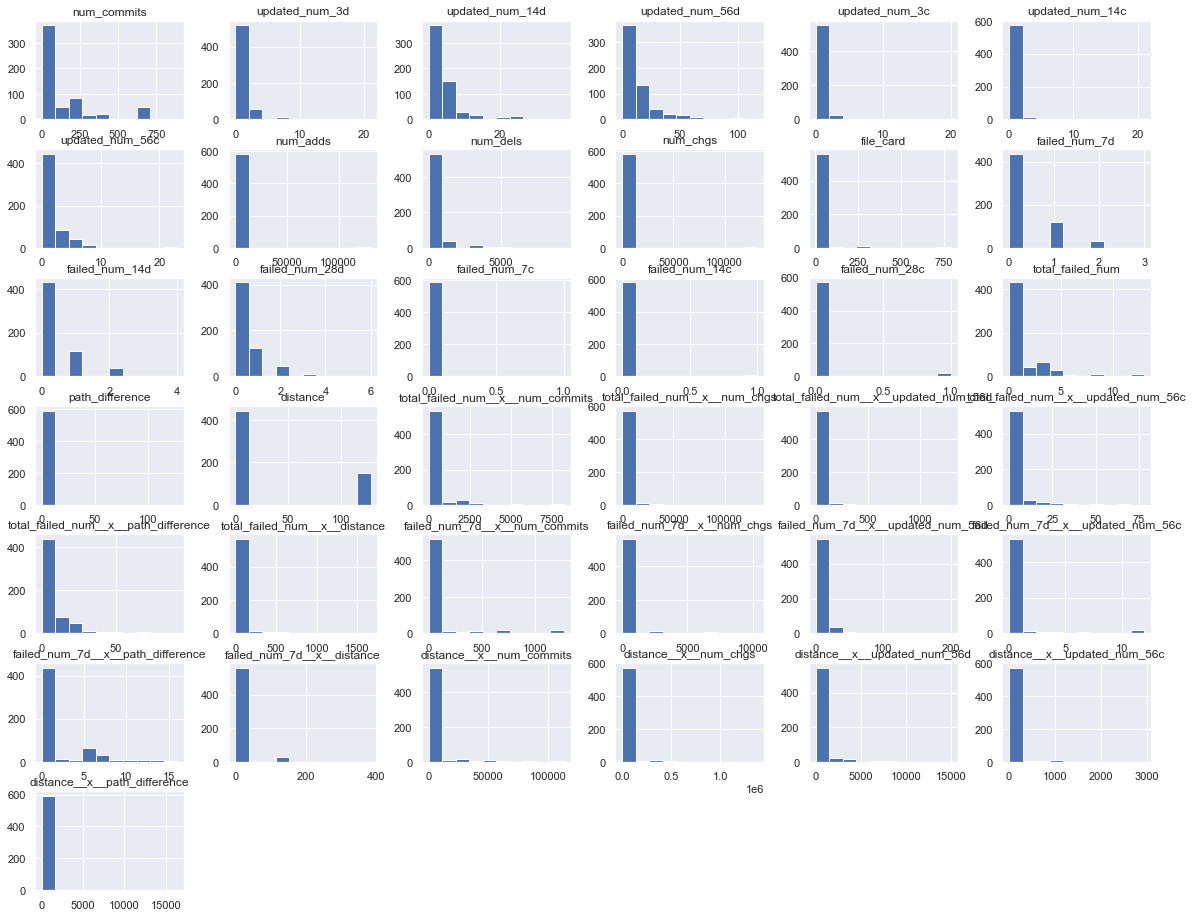

In [20]:
to_histogram_seaborn_numeirc_only(X)

In [21]:
def to_splom_altair(X, target):
    import altair as alt
    chart = alt.Chart(X).mark_circle().encode(
        alt.X(alt.repeat("column"), type='quantitative'),
        alt.Y(alt.repeat("row"), type='quantitative'),
        color=f'{target}:N'
    )
    chart = chart.properties(width=100, height=100)
    chart = chart.repeat(
        row=X.columns.tolist(),
        column=X.columns.tolist()
    )
    return chart

In [22]:
to_splom_altair(pdf, target='failed')

alt.RepeatChart(...)

In [23]:
def to_corr_heatmap(X):    
    import matplotlib.pyplot as plt
    import seaborn as sns
    fig = plt.figure(figsize=(10, 8))
    return sns.heatmap(X.corr(method='pearson'), vmax=1, vmin=-1, center=0, ax=fig.gca())

<AxesSubplot:>

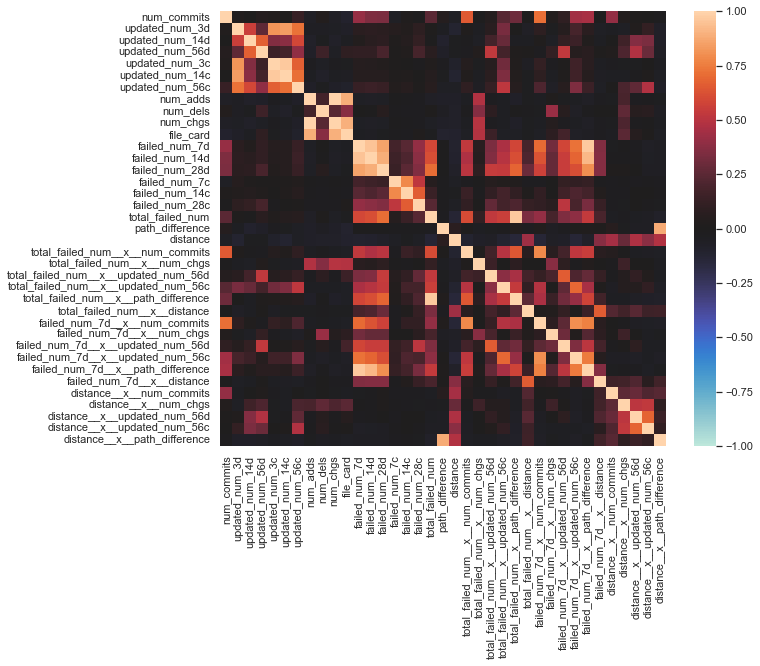

In [24]:
to_corr_heatmap(X)

In [25]:
def compute_mi_between_features(X):
    from minepy import MINE
    results = []
    mine = MINE(alpha=0.6, c=15, est="mic_approx")

    import itertools
    for c1, c2 in itertools.combinations(X.columns, 2):
        mine.compute_score(X[c1], X[c2])
        results.append(((c1, c2), mine.mic()))

    return sorted(results, key=lambda x: x[1], reverse=True)

In [26]:
mi_between_fts = compute_mi_between_features(X)
print(mi_between_fts[0:3])

[(('num_adds', 'num_chgs'), 0.9777555540059409), (('total_failed_num', 'total_failed_num__x__path_difference'), 0.9132279473911179), (('total_failed_num', 'total_failed_num__x__num_chgs'), 0.9096022564022739)]


In [27]:
def compute_mi_against(target, X):
    from minepy import MINE
    results = []
    mine = MINE(alpha=0.6, c=15, est="mic_approx")

    for c in X.columns:
        mine.compute_score(y, X[c])
        results.append(((target, c), mine.mic()))

    return sorted(results, key=lambda x: x[1], reverse=True)

In [28]:
mi_against_target = compute_mi_against('failed', X)
selected_features_with_mi = list(map(lambda x: x[0][1], mi_against_target))[0:16]
print(mi_against_target[0:3])

[(('failed', 'failed_num_7d__x__num_chgs'), 0.500889147078916), (('failed', 'total_failed_num__x__num_chgs'), 0.4943924591554842), (('failed', 'failed_num_7d__x__path_difference'), 0.4478821797143224)]


In [29]:
def select_features_with_bruta(X, y, is_discrete=True):
    from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
    from boruta import BorutaPy
    model_class = RandomForestClassifier if is_discrete else RandomForestRegressor
    rf = model_class(n_jobs=-1, max_depth=5)
    rf.fit(X, y)
    print('SCORE with ALL Features: %1.2f' % rf.score(X, y))

    rf = model_class(n_jobs=-1, max_depth=5)
    fs = BorutaPy(rf, n_estimators='auto', random_state=42, perc=80, two_step=False, max_iter=500)
    fs.fit(X.values, y.values)

    selected = fs.support_
    X_selected = X[X.columns[selected]]
    rf = model_class(n_jobs=-1, max_depth=5)
    rf.fit(X_selected, y)
    print('SCORE with selected Features: %1.2f' % rf.score(X_selected, y))
    
    return X.columns[selected]

In [30]:
selected_features_with_bruta = select_features_with_bruta(X, y, is_discrete=True)

SCORE with ALL Features: 0.94
SCORE with selected Features: 0.95


In [31]:
columns_selected = X.columns
# columns_selected = selected_features_with_bruta
# columns_selected = selected_features_with_mi
columns_selected

Index(['num_commits', 'updated_num_3d', 'updated_num_14d', 'updated_num_56d',
       'updated_num_3c', 'updated_num_14c', 'updated_num_56c', 'num_adds',
       'num_dels', 'num_chgs', 'file_card', 'failed_num_7d', 'failed_num_14d',
       'failed_num_28d', 'failed_num_7c', 'failed_num_14c', 'failed_num_28c',
       'total_failed_num', 'path_difference', 'distance',
       'total_failed_num__x__num_commits', 'total_failed_num__x__num_chgs',
       'total_failed_num__x__updated_num_56d',
       'total_failed_num__x__updated_num_56c',
       'total_failed_num__x__path_difference', 'total_failed_num__x__distance',
       'failed_num_7d__x__num_commits', 'failed_num_7d__x__num_chgs',
       'failed_num_7d__x__updated_num_56d',
       'failed_num_7d__x__updated_num_56c',
       'failed_num_7d__x__path_difference', 'failed_num_7d__x__distance',
       'distance__x__num_commits', 'distance__x__num_chgs',
       'distance__x__updated_num_56d', 'distance__x__updated_num_56c',
       'distance__x

In [32]:
X_selected = X[columns_selected]

In [33]:
def to_pca(X, y, target):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    _X = pca.fit_transform(X)
    _X = pd.DataFrame({'PCA-X': _X[:, 0], 'PCA-Y': _X[:, 1], target: y})

    import matplotlib.pyplot as plt
    import seaborn as sns
    fig = plt.figure(figsize=(10, 8))
    return sns.scatterplot(data=_X, x='PCA-X', y='PCA-Y', hue=target, ax=fig.gca())

<AxesSubplot:xlabel='PCA-X', ylabel='PCA-Y'>

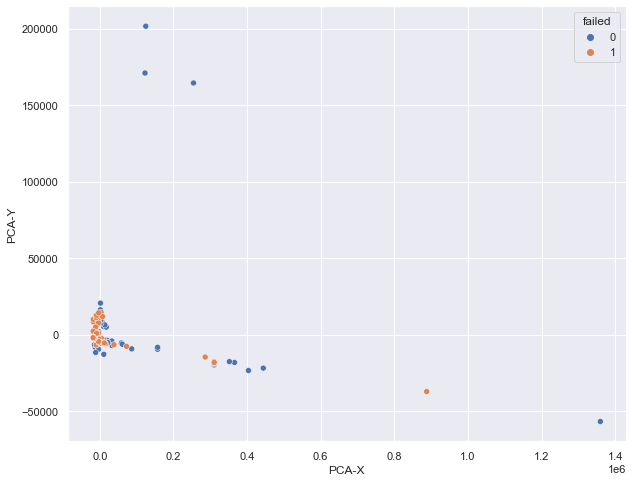

In [34]:
to_pca(X_selected, y, target='failed')

In [35]:
def to_tsne(X, y, target, nsample=100, perplexity=50, n_iter=10000):
    # One of non-linear embedding in sklearn
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, n_iter=n_iter)
    _pdf = X.copy(deep=True)
    _pdf[target] = y
    _pdf_sampled = _pdf.sample(n=nsample, random_state=42)
    _X = _pdf_sampled[_pdf_sampled.columns[_pdf_sampled.columns != target]]
    _y = _pdf_sampled[target]
    _tf = tsne.fit_transform(_X)
    _X = pd.DataFrame({'tSNE-X': _tf[:, 0], 'tSNE-Y': _tf[:, 1], target: _y})
    print('KL divergence: {}'.format(tsne.kl_divergence_))

    import matplotlib.pyplot as plt
    import seaborn as sns
    fig = plt.figure(figsize=(10, 8))
    return sns.scatterplot(data=_X, x='tSNE-X', y='tSNE-Y', hue=target, ax=fig.gca())

KL divergence: 0.15844789147377014


<AxesSubplot:xlabel='tSNE-X', ylabel='tSNE-Y'>

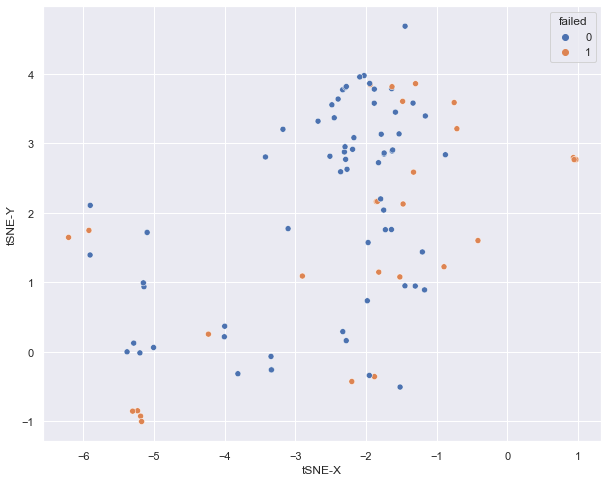

In [36]:
to_tsne(X_selected, y, target='failed', nsample=100, perplexity=50, n_iter=10000)

In [37]:
def to_umap(X, y, target, n_neighbors=5, min_dist=0.3, metric='euclidean'):
    from umap import UMAP
    umap = UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
    _data = umap.fit_transform(X)
    _X = pd.DataFrame({'tSNE-X': _data[:, 0], 'tSNE-Y': _data[:, 1], target: y})

    import altair as alt
    chart = alt.Chart(_X).mark_point().encode(x='tSNE-X', y='tSNE-Y', color=f'{target}:N').properties(width=600, height=400).interactive()
    return chart

In [38]:
to_umap(X_selected, y, target='failed', n_neighbors=300, min_dist=1.0, metric='euclidean')

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


alt.Chart(...)

In [39]:
def reduce_dim(X, y, target, n_components=2, n_neighbors=5, min_dist=0.3, metric='euclidean'):
    from umap import UMAP
    umap = UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, random_state=42)
    _data = umap.fit_transform(X)
    _columns = list(map(lambda x: f'UMAP-{x}', range(0, n_components)))
    return pd.DataFrame(_data, columns=_columns), umap

In [40]:
# X_selected, _ = reduce_dim(X_selected, y, target='failed', n_components=18, n_neighbors=300, min_dist=1.0, metric='euclidean')

In [41]:
from ptesting import train
params = {'hp.timeout': '3600', 'hp.no_progress_loss': '1'}
clf, score = train.build_model(X_selected, y, opts=params)
print(f'Score: {score}')

Score: 0.9582954388008914


In [42]:
list(sorted(filter(lambda x: x[1] > 0.0, zip(clf.feature_name_, clf.feature_importances_)), key=lambda x: x[1], reverse=True))

[('failed_num_7d__x__path_difference', 3470.2944978000596),
 ('failed_num_7d', 2484.652232646942),
 ('failed_num_14d', 2409.385254740715),
 ('failed_num_7d__x__num_chgs', 2095.4833568632603),
 ('total_failed_num__x__path_difference', 1888.575008818647),
 ('total_failed_num__x__num_chgs', 1344.563830429688),
 ('total_failed_num__x__updated_num_56d', 1263.3337186765857),
 ('updated_num_56c', 1262.1016943985596),
 ('failed_num_7d__x__updated_num_56d', 1189.0308206118643),
 ('total_failed_num__x__num_commits', 1068.6901459544897),
 ('failed_num_28d', 1030.0289787054062),
 ('total_failed_num', 1024.6881223842502),
 ('distance__x__path_difference', 947.371755302418),
 ('updated_num_14d', 943.2730992548168),
 ('distance__x__updated_num_56d', 858.4267329815775),
 ('failed_num_7d__x__distance', 839.7169274687767),
 ('num_dels', 826.7085799083579),
 ('distance__x__num_commits', 805.5934313163161),
 ('distance__x__num_chgs', 792.9564094487578),
 ('num_commits', 716.1744807623327),
 ('file_card', 

In [43]:
probs = clf.predict_proba(test_pdf[columns_selected])
pmf = map(lambda p: {"classes": clf.classes_.tolist(), "probs": p.tolist()}, probs)
pmf = map(lambda p: json.dumps(p), pmf)
df = spark.createDataFrame(pd.DataFrame({'sha': test_pdf['sha'], 'test': test_pdf['test'], 'pmf': list(pmf)}))
df = df.selectExpr('sha', 'test', 'from_json(pmf, "classes array<string>, probs array<double>") pmf')
df = df.selectExpr('sha', 'test', 'map_from_arrays(pmf.classes, pmf.probs) pmf')
df = df.selectExpr('sha', 'test', 'pmf["1"] failed_prob', 'pmf["1"] >= 0.50 predicted')
df = df.join(test_df, 'sha', 'INNER').selectExpr('sha', 'test', 'failed_prob', 'size(failed_tests) > 0 failed', 'predicted', 'failed_tests')

extract_test = 'transform(files.file.name, f -> replace(regexp_extract(f, "\/(org\/apache\/spark\/[a-zA-Z0-9/\-]+Suite)\.scala$", 1), "/", "."))'
updated_test_df = test_df.selectExpr('sha', f'filter({extract_test}, f -> length(f) > 0) updated_tests')
corrected_failed_prob = 'case when array_contains(updated_tests, test) then 1.0 else failed_prob end failed_prob'
df = df.join(updated_test_df, 'sha', 'INNER').selectExpr('sha', 'test', corrected_failed_prob, 'failed', 'predicted', 'failed_tests')

<AxesSubplot:>

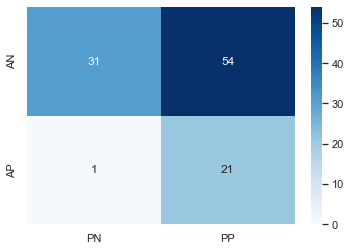

In [44]:
from pyspark.sql import functions as f
prob_thres = 0.50
predicted_pdf = df.groupBy('sha').agg(f.expr('first(failed) failed'), f.expr('array_max(collect_set(failed_prob)) failed_prob')).selectExpr('failed', f'failed_prob >= {prob_thres} predicted', 'failed_prob').toPandas()

import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(predicted_pdf['failed'], predicted_pdf['predicted'])
sns.heatmap(pd.DataFrame(cm, index=['AN', 'AP'], columns=['PN', 'PP']), annot=True, cmap='Blues', vmin=0)

In [45]:
from sklearn.metrics import classification_report
pd.DataFrame(classification_report(predicted_pdf['failed'], predicted_pdf['predicted'], target_names=['passed', 'failed'], output_dict=True))

,passed,failed,accuracy,macro avg,weighted avg
precision,0.968750,0.280000,0.485981,0.624375,0.827138
recall,0.364706,0.954545,0.485981,0.659626,0.485981
f1-score,0.529915,0.432990,0.485981,0.481452,0.509986
support,85.000000,22.000000,0.485981,107.000000,107.000000


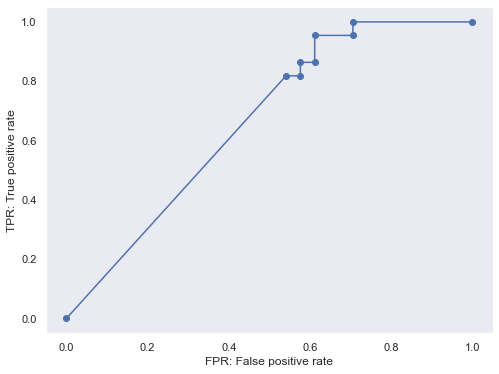

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

fpr, tpr, thres = roc_curve(predicted_pdf['failed'], predicted_pdf['failed_prob'])

sns.set()
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

In [47]:
rank_df = df.groupBy('sha').agg(f.expr('first(failed_tests) failed_tests'), f.expr('collect_set(named_struct("t", test, "p", failed_prob)) tests'))
rank_df = rank_df.selectExpr('sha', 'explode(failed_tests) failed_test', 'array_sort(tests, (l, r) -> case when l.p < r.p then 1 when l.p > r.p then -1 else 0 end) tests')
rank_df = rank_df.selectExpr('sha', 'failed_test', 'tests.t tests').selectExpr('sha', 'failed_test', 'array_position(tests, failed_test) rank')
rank_df = rank_df.selectExpr('sha', 'failed_test', 'case when rank = 0 then 1800 else rank end rank')
rank_pdf = rank_df.toPandas()
rank_pdf

,sha,failed_test,rank
0,6227f49e2f407b9e07c03b3c124eb679248065c1,org.apache.spark.SparkThrowableSuite,2
1,cc0808fcd0cf9817aa24a71956f991f6b81452d8,org.apache.spark.sql.hive.execution.SQLMetrics...,1800
2,a09e37faec1be04a20785846f9a2b53c8fdfd663,org.apache.spark.sql.catalyst.analysis.Analysi...,2
3,b2bb00d9ea53668e952c0fed3ff3ae9ba0ed8615,org.apache.spark.sql.hive.HiveExternalCatalogV...,7
4,b2bb00d9ea53668e952c0fed3ff3ae9ba0ed8615,org.apache.spark.sql.DataFrameSuite,1
...,...,...,...
90,7ab319627d56c0d9ed277c9b15f59e89e933e24f,org.apache.spark.sql.SQLQueryTestSuite,27
91,7ab319627d56c0d9ed277c9b15f59e89e933e24f,org.apache.spark.sql.DateFunctionsSuite,24
92,8db8b50e0621b46e6572ec72c1cc9aeca2a66807,org.apache.spark.sql.catalyst.analysis.Analysi...,27
93,8db8b50e0621b46e6572ec72c1cc9aeca2a66807,org.apache.spark.sql.SQLQueryTestSuite,7


In [48]:
coverage = []
num_rank_df = rank_df.count()
for t in [250, 500, 750, 1000]:
    coverage.append(rank_df.where(f'rank < {t}').count() / num_rank_df)
    
print(coverage)

[0.9368421052631579, 0.9473684210526315, 0.968421052631579, 0.968421052631579]


Text(0, 0.5, 'Cumulative ratio')

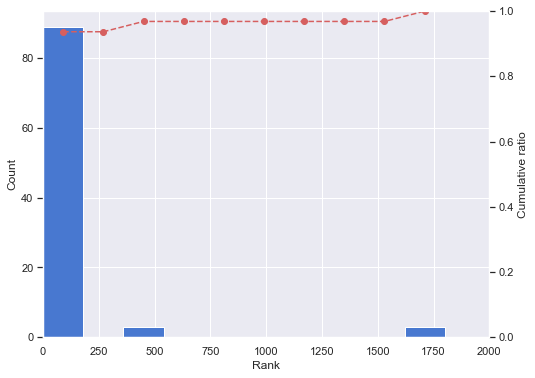

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid", palette="muted", color_codes=True)

fig, ax1 = plt.subplots(figsize=(8, 6))
n, bins, patches = ax1.hist(rank_pdf['rank'])
ax1.set_xlim([0, 2000])
ax1.set_xlabel("Rank")
ax1.set_ylabel("Count")

ax2 = ax1.twinx()
y2 = np.add.accumulate(n) / n.sum()
x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]
lines = ax2.plot(x2, y2, ls='--', color='r', marker='o')
ax2.set_xlim([0, 2000])
ax2.set_ylim([0.0, 1.0])
ax2.grid(visible=False)
ax2.set_ylabel('Cumulative ratio')

In [50]:
failed_tests['org.apache.spark.sql.jdbc.v2.DB2IntegrationSuite']

['2021/06/30 20:22:02']

In [51]:
def compute_distance(src, dst):
    visited_nodes = set()
    keys = list([src])
    for i in range(0, 16):
        if len(keys) == 0:
            return -1

        next_keys = set()
        for key in keys:
            if key in dep_graph and key not in visited_nodes:
                nodes = dep_graph[key]
                next_keys.update(nodes)
        if dst in next_keys:
            return i + 1

        visited_nodes.update(keys)
        keys = list(next_keys)

    return -1

In [52]:
compute_distance(src='org.apache.spark.sql.hive.execution.OptimizedCreateHiveTableAsSelectCommand', dst='org.apache.spark.sql.hive.execution.HiveWindowFunctionQuerySuite')
# compute_distance(src='org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils', dst='org.apache.spark.sql.execution.datasources.jdbc.JDBCRDD')

-1

In [53]:
target_sha = 'd03a64cf0b4e5e303c35acabab84315b9247b09b'
# test_df.where(f'sha = "{target_sha}"').toPandas().to_dict(orient='records')
# test_feature_df.join(df, ['sha', 'test'], 'INNER').where(f'sha == "{target_sha}" AND array_contains(failed_tests, test)').selectExpr('test', 'failed_prob').toPandas().to_dict(orient='records')
test_df.join(df, ['sha'], 'INNER').where(f'sha == "{target_sha}"').limit(1).toPandas().to_dict(orient='records')

[]

In [54]:
# list(filter(lambda c: c.endswith('Suite'), corr_map['sql/hive/src/main/scala/org/apache/spark/sql/hive/HiveSessionCatalog.scala']))
# corr_map['sql/catalyst/src/main/scala/org/apache/spark/sql/catalyst/catalog/SessionCatalog.scala']
# corr_map['sql/core/src/main/scala/org/apache/spark/sql/execution/adaptive/AdaptiveSparkPlanExec.scala']
# dep_graph['org.apache.spark.sql.hive.HiveSessionCatalog']

In [55]:
import json
tdf = rank_df.join(test_df, 'sha', 'INNER').selectExpr('sha', 'rank', 'failed_test', 'files.file.name filenames').orderBy(f.expr('rank').desc()).toPandas()
print(json.dumps(tdf.to_dict(orient='records'), indent=2))

[
  {
    "sha": "cc0808fcd0cf9817aa24a71956f991f6b81452d8",
    "rank": 1800,
    "failed_test": "org.apache.spark.sql.hive.execution.SQLMetricsSuite",
    "filenames": [
      "sql/hive-thriftserver/src/test/scala/org/apache/spark/sql/hive/thriftserver/CliSuite.scala",
      "sql/hive-thriftserver/src/test/scala/org/apache/spark/sql/hive/thriftserver/HiveThriftServer2Suites.scala"
    ]
  },
  {
    "sha": "f6fd8a38300f930a6d2752572c031e7befabff00",
    "rank": 1800,
    "failed_test": "org.apache.spark.sql.hive.execution.command.ShowTablesSuite",
    "filenames": [
      "sql/catalyst/src/main/scala/org/apache/spark/sql/catalyst/analysis/NoSuchItemException.scala"
    ]
  },
  {
    "sha": "533cb7ca056e746ce0d4047662e0ae5574d47c36",
    "rank": 1800,
    "failed_test": "org.apache.spark.sql.sources.BucketedReadWithHiveSupportSuite",
    "filenames": [
      "sql/catalyst/src/main/scala/org/apache/spark/sql/catalyst/expressions/Cast.scala",
      "sql/catalyst/src/main/scala/org/apac